-Libraries-
-

In [214]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pygad
import matplotlib.pyplot as plt

-Functions-
-

Preprocessing
* For the preprocessing, the needed data from the csv file are extracted and reshaped  in a way that they may be easily used from the genetic algorithm. After only the inscriptions that match the region id 1963 are extracted in a new data frame (df_GSyria), a Bag of Words model combining it with the tf-idf metric is implemented. For this job a Tf-Idf Vectorizer is used, converting the text data of the inscriptions(df_GSyria['text']) to a TF-IDF matrix(X). The vocabulary (dicts) is generated by the vectorizer. In order for both the incomplete phrase and the inscriptions to be encoded with the same vectorizer, if the words of the incomplete phrase are not included in the dictionary created by the vectorizer, they are added to it. The process of encoding is repeated with the new dictionary for both the incomplete phrase and the inscriptions.

In [215]:
def check_existence(dicts, target_word1, target_word2):
    if target_word1 not in dicts:
        dicts[target_word1] = len(dicts)
    if target_word2 not in dicts:
        dicts[target_word2] = len(dicts)
    return dicts

def preprocess(filename, target_word1, target_word2):
    # Import CSV
    df = pd.read_csv(filename, delimiter='\t')
    df_GSyria = df[df['region_main_id'] == 1693]

    vectorizer = TfidfVectorizer()

    X = vectorizer.fit_transform(df_GSyria['text'].to_list())

    # Vocabulary Generated from tf-idf vectorizer
    dicts = vectorizer.vocabulary_

    dicts = check_existence(dicts, target_word1, target_word2)

    vectorizer = TfidfVectorizer(vocabulary=dicts)
    X_updated = vectorizer.fit_transform(df_GSyria['text'].to_list())
    dicts_updated = vectorizer.vocabulary_

    target_phrase = f"{target_word1} {target_word2}"
    phrase_vector = vectorizer.fit_transform([target_phrase])
    
    return phrase_vector, X_updated, dicts_updated, target_phrase, df_GSyria, vectorizer

5 Most Similar Descriptions
* Functions that locates the 5 most similar inscriptions to the incomplete phrase using cosine similarity.

In [216]:
def similarity(phrase_vector, X_updated, target_phrase, df_GSyria):
    similarities = cosine_similarity(phrase_vector, X_updated).flatten()

    desc_similarity_indices = similarities.argsort()[::-1]

    print("Top 5 similar phrases to '{}':".format(target_phrase))
    for idx in desc_similarity_indices[:5]:
        print("Phrase: {}, Similarity: {:.4f}".format(df_GSyria.iloc[idx]['text'], similarities[idx]))

    return desc_similarity_indices, similarities

GA Setup

    Fitness Function
* The fitness function completes the incomplete phrase for each solution, encodes it and calculates the mean of its cosine similarity with each of the 5 most similar inscriptions to the incomplete phrase.

In [217]:
def get_word(index):
    for word, idx in dicts_updated.items():
        if idx == index:
            return word
    return None
    
def fitness_function(ga_instance, solution, solution_idx,):
    phrase_similarities = []
    idx1, idx2 = int(solution[0]), int(solution[1])
    word1 = get_word(idx1)
    word2 = get_word(idx2)
    
    completed_phrase=f"{word1} {target_phrase} {word2}"
    completed_phrase_vector = vectorizer.fit_transform([completed_phrase])
    
    for idx in desc_similarity_indices[:5]:
        phrase_similarity = cosine_similarity(completed_phrase_vector, X_updated[idx]).flatten()
        phrase_similarities.append(phrase_similarity)
    
    overall_similarity = sum(phrase_similarities)/len(phrase_similarities)
    return overall_similarity

    Early Stopping Function

* In order to stop the run after a specific number of generations(1000) is reached, the num_generations parameter is set to that number. To stop the run when there has been very little (<1%) or no improvement for a number of consecutive generation the custom function (on_generation) compares the current best fitness with the previous.

In [218]:
num_generations = 1000
crossover_type = "single_point"
parent_selection_type = "rws"
mutation_type = "random"
improvement_threshold = 0.01
no_improvement_count = 0
consecutive_gens = 100
previous_best = -np.inf

def on_generation(ga_instance):
    global no_improvement_count, previous_best

    current_best = ga_instance.best_solution()[1]

    if previous_best != -np.inf:
        improvement = (current_best - previous_best) / abs(previous_best)
        if improvement < improvement_threshold: 
            no_improvement_count += 1
        else:
            no_improvement_count = 0

    if no_improvement_count >= consecutive_gens:
        return "stop"

    previous_best = current_best



    Instance Creation Function
* num_generations: number of generations reached for the run to stop,
* num_parents_mating: number of parents to mate in each generation,
* fitness_func: fitness function,
* initial_population: initial population,
* parent_selection_type: parent selection type (rws),
* keep_elitism: whether or not elisim is used and how many solutions will be kept (1),
* crossover_type= crossover type (single_point),
* crossover_probability: crossover probability,
* mutation_type: mutation type (random),
* mutation_by_replacement: whether random mutation will replace gene or add random value to it,
* mutation_probability: mutation probability,
* gene_space: possible values for each gene,
* on_generation: function called on each generation- used for early stopping,
* suppress_warnings: suppress warnings

In [219]:
def set_up_ga_instance(population_size, crossover_probability, mutation_probability, initial_population):
    
    ga_instance = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=population_size,
        fitness_func=fitness_function,
        initial_population=initial_population,
        parent_selection_type=parent_selection_type,
        keep_elitism=1,
        crossover_type= crossover_type,
        crossover_probability=crossover_probability,
        mutation_type=mutation_type,
        mutation_by_replacement= True,
        mutation_probability= mutation_probability,
        gene_space=list(range(0, vocab_size)),
        # on_generation=on_generation,
        suppress_warnings=True
    )
    return ga_instance

    Instance Run Function
* For each run of a ga instance: the best solution and the words corresponding to it, the generation that the instance terminated and the fitness of all its solutions are kept.

In [220]:
def run_instance(ga_instance):
        ga_instance.run()
        solution, solution_fitness, solution_idx = ga_instance.best_solution()
        idx1, idx2 = int(solution[0]), int(solution[1])
        word1 = get_word(idx1)
        word2 = get_word(idx2)
        last_generation = ga_instance.generations_completed
        run_best_solutions = ga_instance.best_solutions_fitness
        return solution_fitness, last_generation, word1, word2, run_best_solutions

Query Module

    Function that computs for each parameter combination: mean fitness and number of generations to completion and best solution.
* For each of the 10 runs of each combination of parameters the mean of the fitness value, the mean of the generations to completion and the best solution are compluted.

In [221]:
def compute_mean_fitness_and_best_solution(results):
    best_fitness_values = [result['best_fitness'] for result in results]
    mean_best_fitness = sum(best_fitness_values) / len(best_fitness_values)
    
    num_generations_values = [result['num_generations'] for result in results]
    mean_num_generations = sum(num_generations_values) / len(num_generations_values)
    
    best_solution_fitness = max(best_fitness_values)
    best_solution_index = best_fitness_values.index(max(best_fitness_values))
    best_solution = results[best_solution_index]['best_solution']

    return mean_best_fitness, mean_num_generations, best_solution_fitness, best_solution

    Best Overall Solution and Fitness Function.
  * The best solution of all the parameter combinations and its fitness are computed.

In [222]:
def get_solution(final_results):
    best_fitness_overall = [result['best_solution_fitness'] for result in final_results]
    best_overall_fitness = max(best_fitness_overall)
    index = best_fitness_overall.index(max(best_fitness_overall))
    best_solution_overall = final_results[index]['best_solution']
    return best_solution_overall, best_overall_fitness


Plots

* These two functions are called in the first loop for each parameter combination to create the 10 plots.

    Preprocessing Fitness and Generation Values For Plotting Function
* For each parameter combination padding is added to the instances' lists of fitness per generation, in order for the mean fitness per generation to be calculated.

In [223]:
def plot_preprocessing(fit_per_gen):
    max_generations =  max(len(run) for run in fit_per_gen)
    
    even_solutions = []
    for run in fit_per_gen:
        padding = run + [None] * (max_generations - len(run))
        even_solutions.append(padding)

    mean_fitness_per_gen = []
    for generation in range(max_generations):
        gen_fitness =  [run[generation][0] for run in even_solutions if run[generation] is not None]
        if gen_fitness:
            mean_fitness = sum(gen_fitness) / len(gen_fitness)
        else:
            mean_fitness = None
        mean_fitness_per_gen.append(mean_fitness)
    return mean_fitness_per_gen
    

    Create Plot Function

In [224]:
def create_plot(mean_fitness_per_gen, population_size, crossover_probability, mutation_probability):
    generations = list(range(len(mean_fitness_per_gen)))
    plt.figure(figsize=(10, 6))
    plt.plot(generations, mean_fitness_per_gen, marker='o', linestyle='-', color='b')
    
    plt.title(f"Mean Fitness per Generation \n"
              f"Population Size: {population_size}, Crossover Probability: {crossover_probability}, Mutation Probability: {mutation_probability}")
    plt.xlabel("Generation")
    plt.ylabel("Mean Fitness")
    
    plt.grid(True)
    plt.show()

-Run-
-

* Parameter combinations are set and preprocess and similarity functions are run.

In [225]:
parameter_combinations = [
    (20, 0.6, 0.00),
    (20, 0.6, 0.01),
    (20, 0.6, 0.10),
    (20, 0.9, 0.01),
    (20, 0.1, 0.01),
    (200, 0.6, 0.00),
    (200, 0.6, 0.01),
    (200, 0.6, 0.10),
    (200, 0.9, 0.01),
    (200, 0.1, 0.01)
]
final_results = []

phrase_vector, X_updated, dicts_updated, target_phrase, df_GSyria, vectorizer = preprocess('iphi2802.csv', 'αλεξανδρε', 'ουδις')

vocab_size=len(dicts_updated)

desc_similarity_indices, similarities = similarity(phrase_vector, X_updated, target_phrase, df_GSyria)


Top 5 similar phrases to 'αλεξανδρε ουδις':
Phrase: μνεμιον πετρος οτιο ετους τκβ περετιου. θαρσι ουδις αθανοτας. θανοντ[ος] ας ετων θαρσι ουδις αθανατος., Similarity: 0.3183
Phrase: μνημιον πετρου ουλπιανου αποθανοντος ετων εξηκοντα εν ετι σπγ εν μηνι ξανθικω λ θαρσι ουδις αθανατος., Similarity: 0.1876
Phrase: εις θεος ο παντων δεσποτης. μνημιον ελλαδιου σαβα αποθανοντος μετα καλου ονοματος και καλης πιστεως ετων δ μηνος διου ε ημερα του. θαρσι ουδις αθανατος., Similarity: 0.1648
Phrase: η βουλ[η και ο δημος ι]ουλιον αυρηλιο[ν σαλαμα]λλαθον μαλη [του αβδαιου α]ρχεμπορον ανακομισ[αντα την συν]οδιαν προικα εξ ιδ[ιων] τειμης χαριν ετους., Similarity: 0.0000
Phrase: μνησθη αννιανος δοφλικαρις ο επισταθις του εργου και ευειλατον ε[χ]ο[ι] την θεαν., Similarity: 0.0000


* 10 instances for each combination of parameters are created and run.
    
    results: holds the mean best fitness, mean generation and the best solution of each parameter combination.
    
    populations: holds the 10 initial populations for each parameter combination.
    
    fit_per_gen: holds fitness per generation for each of the 10 initial populations.

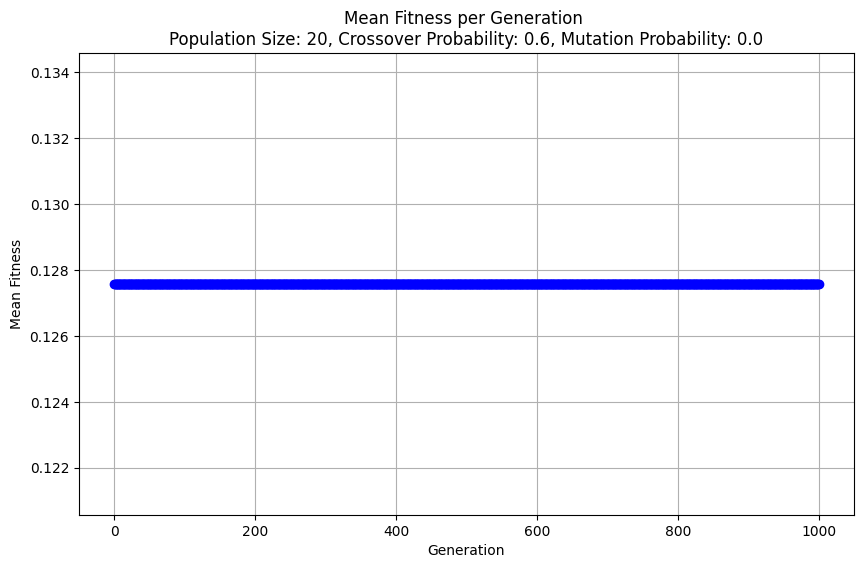

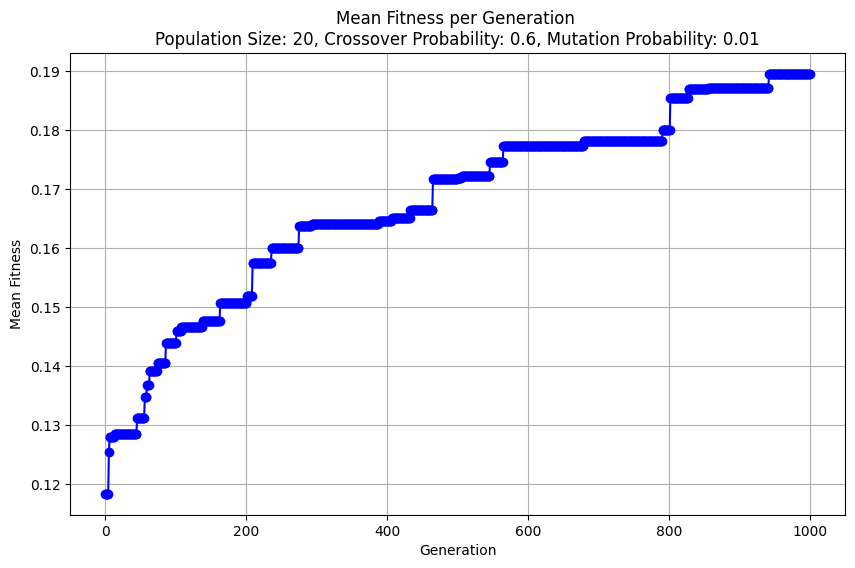

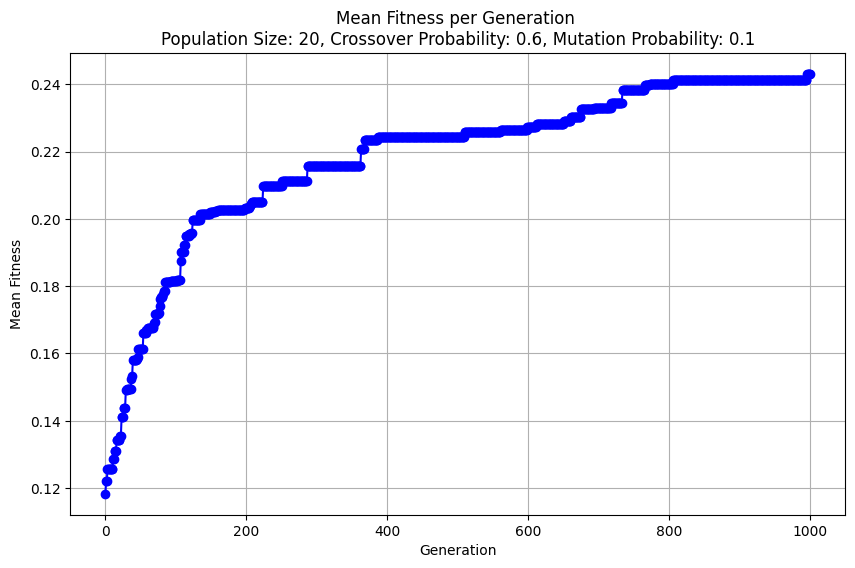

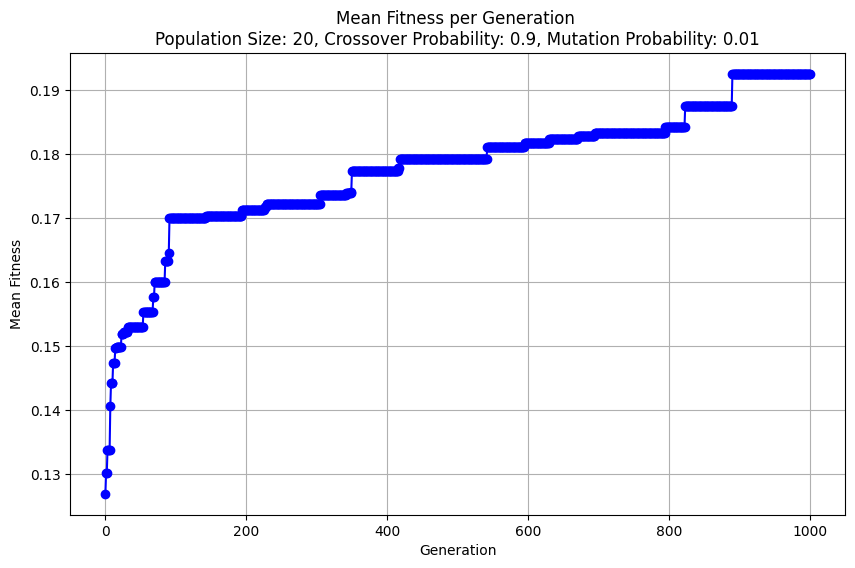

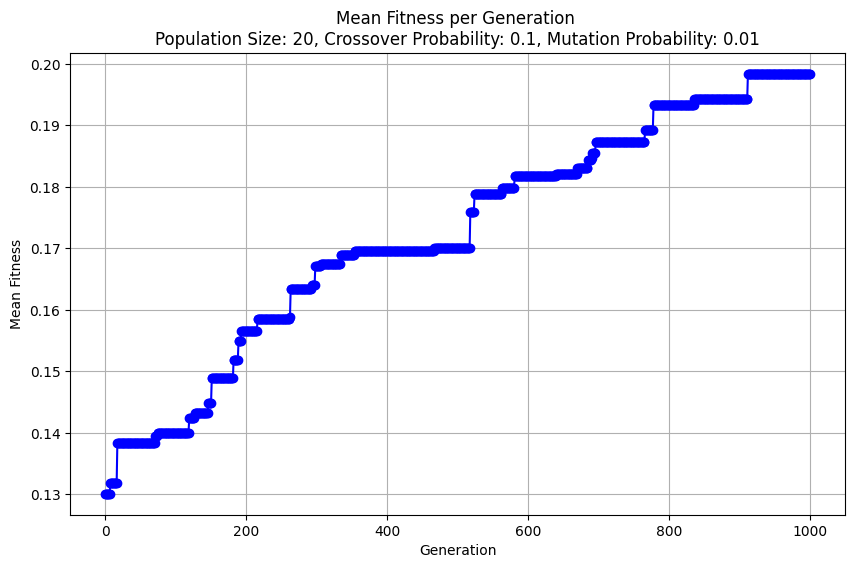

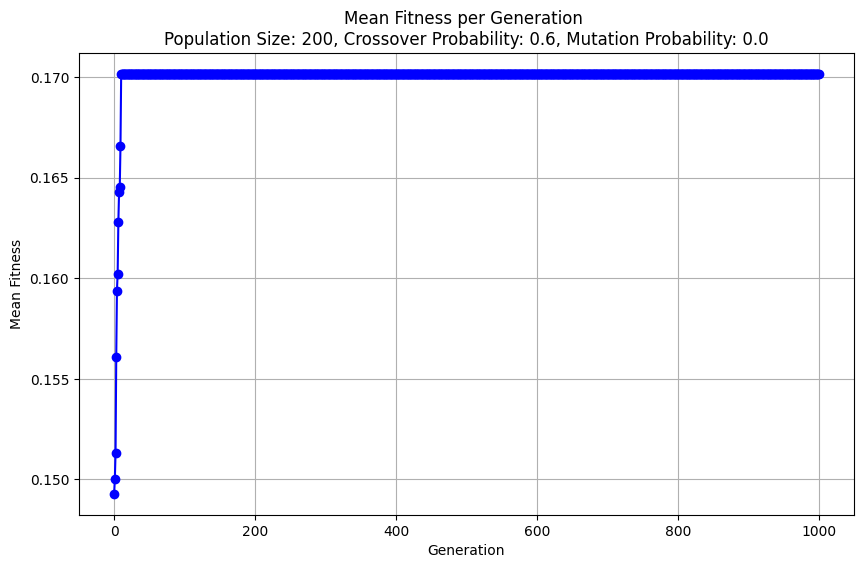

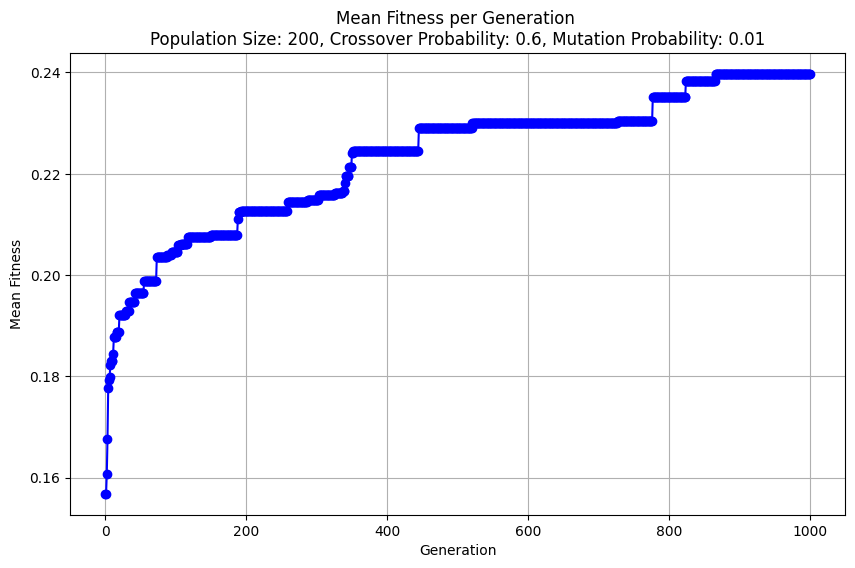

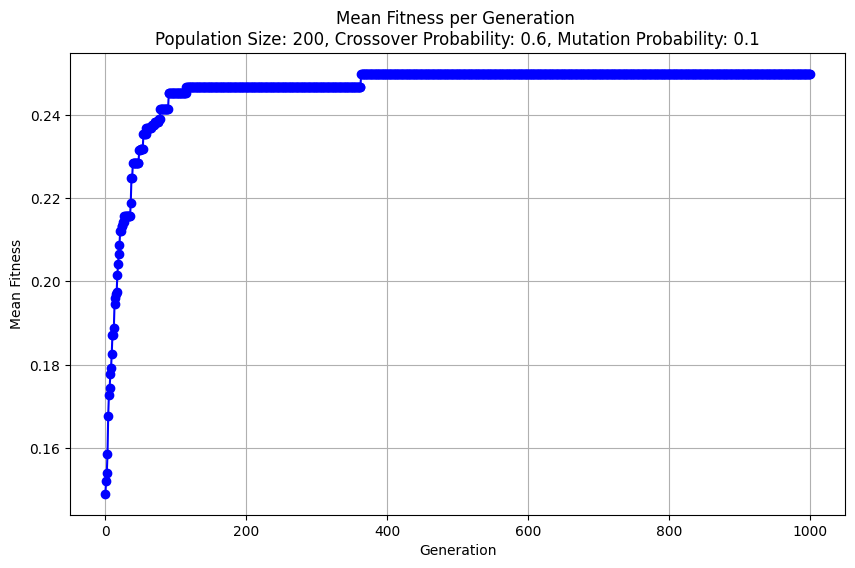

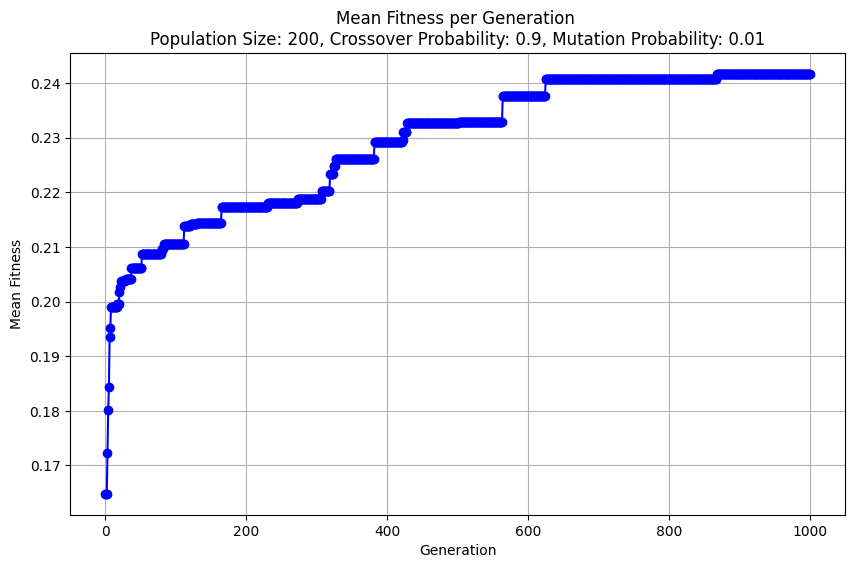

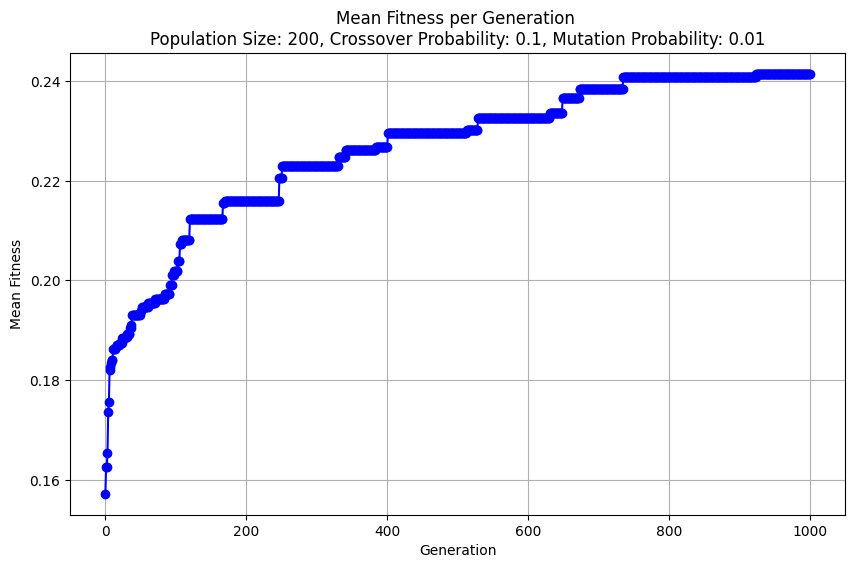

In [226]:

for population_size, crossover_probability, mutation_probability in parameter_combinations:
    results = []
    populations=[]
    fit_per_gen=[]
    for _ in range(10):
        initial_population = np.random.randint(0, vocab_size, size=(population_size, 2))
        populations.append(initial_population)
    

    for initial_population in populations:
        ga_instance = set_up_ga_instance(population_size, crossover_probability, mutation_probability, initial_population)
        solution_fitness,last_generation, word1, word2, run_best_solutions  = run_instance(ga_instance)
        
        results.append({
        'best_solution': (word1, word2),
        'best_fitness': solution_fitness,
        'num_generations': last_generation
        })
        fit_per_gen.append(run_best_solutions)
        
        
    mean_best_fitness, mean_num_generations, best_solution_fitness, best_solution= compute_mean_fitness_and_best_solution(results)

    final_results.append({
        'population_size': population_size, 
        'crossover_probability': crossover_probability, 
        'mutation_probability': mutation_probability,
        'mean_best_fitness':mean_best_fitness,
        'mean_num_generations':mean_num_generations,
        'best_solution':best_solution,
        'best_solution_fitness':best_solution_fitness
    })
    
    mean_fitness_per_gen = plot_preprocessing(fit_per_gen)
    create_plot(mean_fitness_per_gen, population_size, crossover_probability, mutation_probability)
    

Print Final Results

In [227]:
print(final_results)

overall_best_solution, overall_best_fitness = get_solution(final_results)
word_1_result, word_2_result = overall_best_solution
final_phrase = f"{word_1_result} {target_phrase} {word_2_result}"

print(f"The best phrase overall is: {final_phrase}, with fitness: {overall_best_fitness}")

[{'population_size': 20, 'crossover_probability': 0.6, 'mutation_probability': 0.0, 'mean_best_fitness': array([0.12758266]), 'mean_num_generations': 1000.0, 'best_solution': ('εν', 'σαβα'), 'best_solution_fitness': array([0.15172093])}, {'population_size': 20, 'crossover_probability': 0.6, 'mutation_probability': 0.01, 'mean_best_fitness': array([0.18951824]), 'mean_num_generations': 1000.0, 'best_solution': ('ουδις', 'θαρσι'), 'best_solution_fitness': array([0.22530715])}, {'population_size': 20, 'crossover_probability': 0.6, 'mutation_probability': 0.1, 'mean_best_fitness': array([0.24315193]), 'mean_num_generations': 1000.0, 'best_solution': ('θαρσι', 'αθανατος'), 'best_solution_fitness': array([0.24982347])}, {'population_size': 20, 'crossover_probability': 0.9, 'mutation_probability': 0.01, 'mean_best_fitness': array([0.19258183]), 'mean_num_generations': 1000.0, 'best_solution': ('μνημιον', 'θαρσι'), 'best_solution_fitness': array([0.22070661])}, {'population_size': 20, 'crossov